In [1]:
import os
import numpy as np
import PIL.Image
import fastai
import torchvision.transforms as T

from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
from io import BytesIO

# Prevent error
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] + \
                            [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [3]:
# Load model
learn = load_learner('models', 'ArtLine_650.pkl')

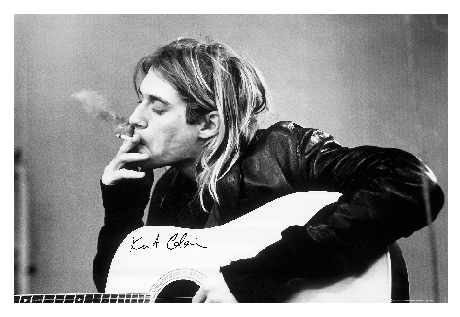

In [4]:
# Load image
img = PIL.Image.open('images/kurt_cobain.png').convert("RGB")  
img_t = T.ToTensor()(img)
img_fast = Image(img_t)
show_image(img_fast, figsize=(8,8), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


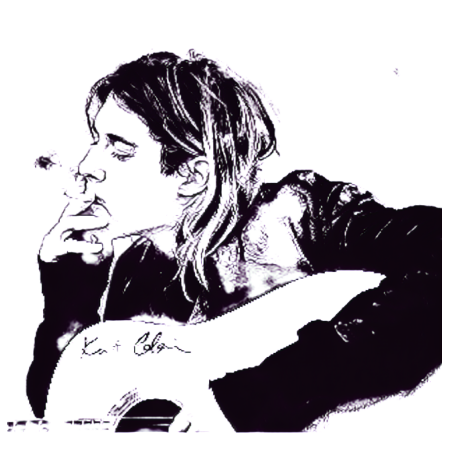

In [5]:
p, img_hr, b = learn.predict(img_fast)
Image(img_hr).show(figsize=(8,8));